This code use Pyemma to model MSM comformational sampling, please refer to the original paper for code details 

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
from pyemma.util.contexts import settings
import mdtraj as md
import deeptime as dt
import sys
sys.path = [x for x in sys.path if ('amber' not in x) and ('Amber' not in x)]
import pytraj as pt

In [18]:
DIR = 'path to folder'
pdb = 'path to folder/1st.pdb' # protein-only .prmtop or .pdb
# a list of all the MD trajectories of protein monomers, water removed
files = ['path to folder/file_1.dcd',
         'path to folder/file_2.dcd',
       ]
#ref = pt.load('path to folder/1st.pdb') # a reference protein structure to align the TRAJ to
traj = pt.iterload(files, pdb)
print(traj)

pytraj.TrajectoryIterator, 30000 frames: 
Size: 0.420436 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, PBC with box type = ortho>
           


In [19]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Ca())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

<Figure size 432x288 with 0 Axes>

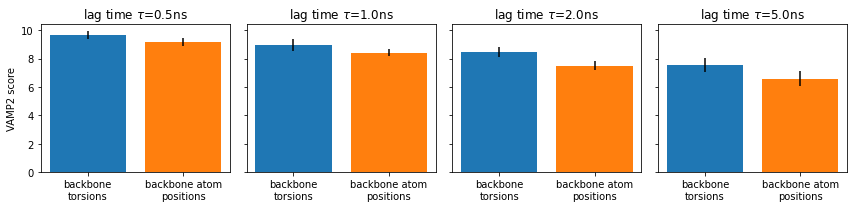

In [20]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):

    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

dim = 10

fig=plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20, 50]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    #distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    #scores += [distances_scores.mean()]
    #errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()
fig.savefig(DIR+'/a14sb_VAMP2_Ca.pdf')

<Figure size 432x288 with 0 Axes>

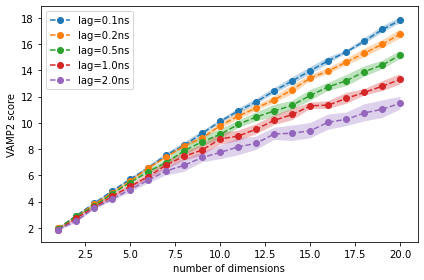

In [5]:
'''
fig=plt.figure()
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(20)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(positions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()
fig.savefig(DIR+'/protein_Dimensions_Ca.pdf')
'''

In [21]:
tica = pyemma.coordinates.tica(positions_data, dim=4)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

<Figure size 432x288 with 0 Axes>

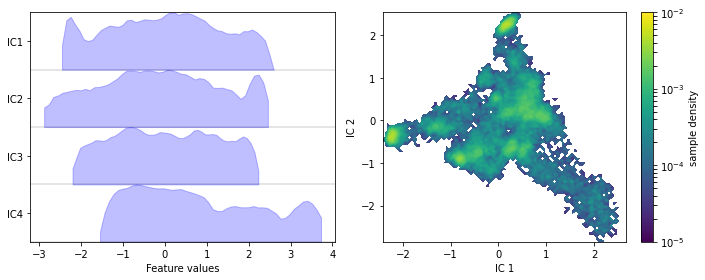

In [22]:
fig=plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)

pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
fig.savefig(DIR+'/a14sb_TICAS_Ca.pdf')

<Figure size 432x288 with 0 Axes>

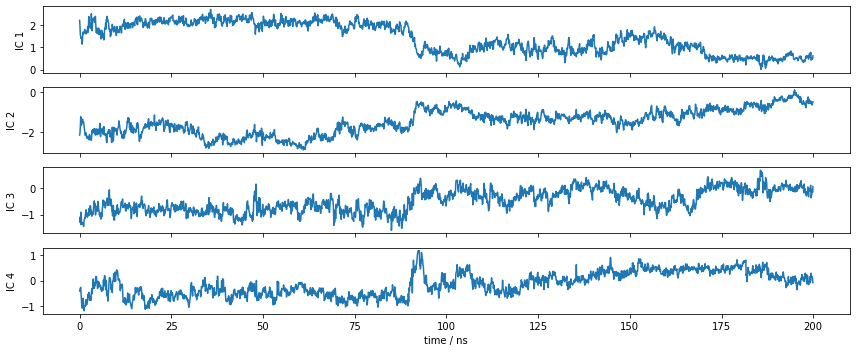

In [8]:
'''
fig=plt.figure()
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
fig.savefig(DIR+'/a14sb_ns_Ca.pdf')
'''

<Figure size 432x288 with 0 Axes>

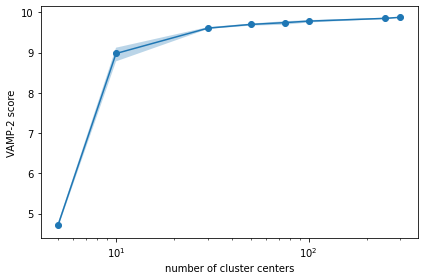

In [23]:
fig=plt.figure()
n_clustercenters = [5, 10, 30, 50, 75, 100, 250, 300]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=1)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()
fig.savefig(DIR+'/ff_number of clusters_Ca.pdf')

In [24]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=100, max_iter=50, stride=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

<Figure size 432x288 with 0 Axes>

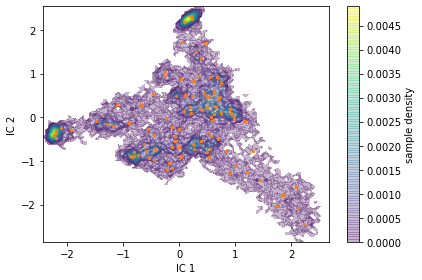

In [25]:
fig=plt.figure()
fig, ax = plt.subplots(figsize=(6, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=True, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
fig.savefig(DIR+'/ff_ICs_with_clusters_Ca.pdf')

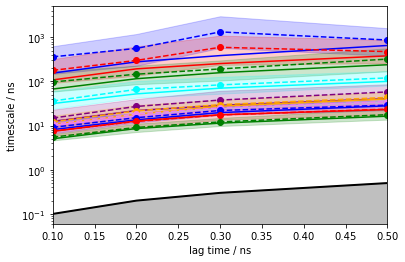

In [26]:
fig=plt.figure()
its = pyemma.msm.its(cluster.dtrajs, lags=5, nits=10, errors="bayes")
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
fig.savefig(DIR+'/ff_implied_timescales_Ca.pdf')

In [31]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


<Figure size 432x288 with 0 Axes>

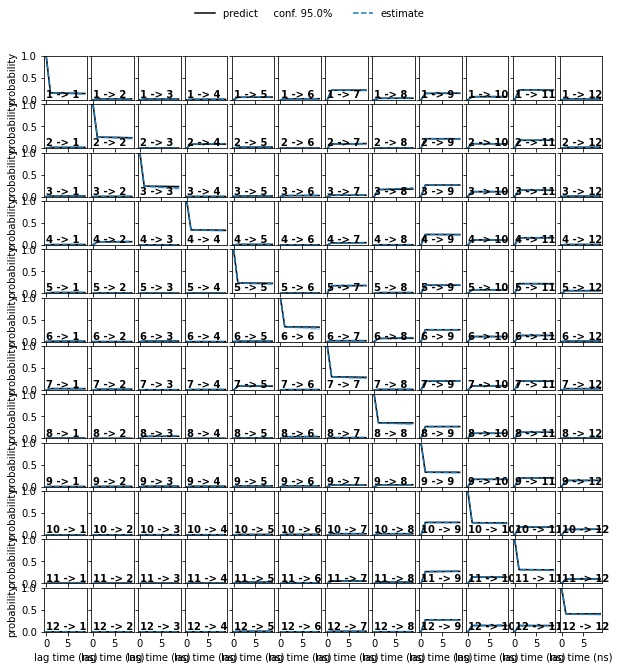

In [12]:
fig=plt.figure()
nstates = 12
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')
fig.savefig(DIR+'/a14sb_CK test_Ca.pdf')

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of ticklabels (11).

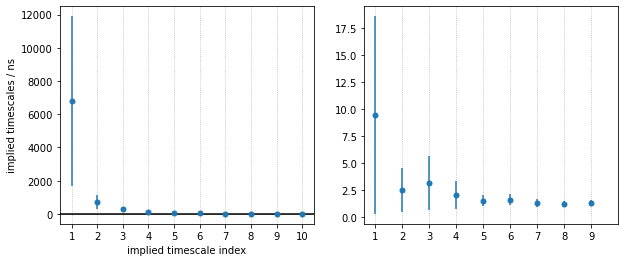

In [39]:
'''
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
'''

<Figure size 432x288 with 0 Axes>

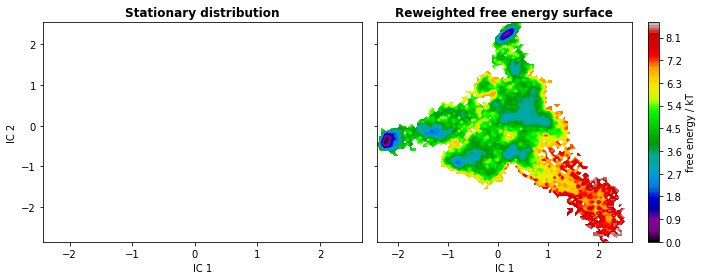

In [13]:
fig=plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
'''
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
'''
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
fig.savefig(DIR+'/a14sb_Distributions_Ca.pdf')

The first eigenvector is one: True (min=0.9999999999965317, max=1.000000000019684)


<Figure size 432x288 with 0 Axes>

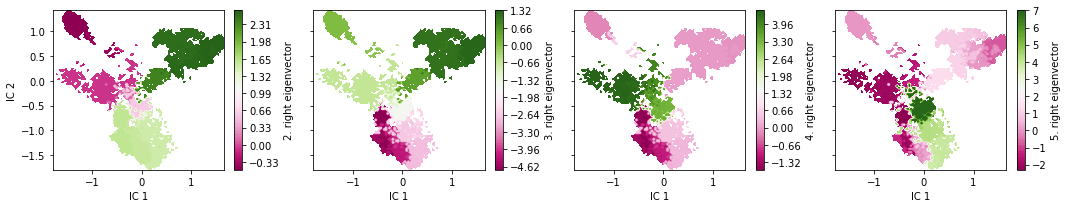

In [42]:
'''
fig=plt.figure()
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()
fig.savefig(DIR+'/bidps_Eigenvectors_Ca.pdf')
'''

In [14]:
msm.pcca(nstates)

PCCA(P=array([[0.58796, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.31897, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.61502, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.59914]]),
   m=12)

<Figure size 432x288 with 0 Axes>

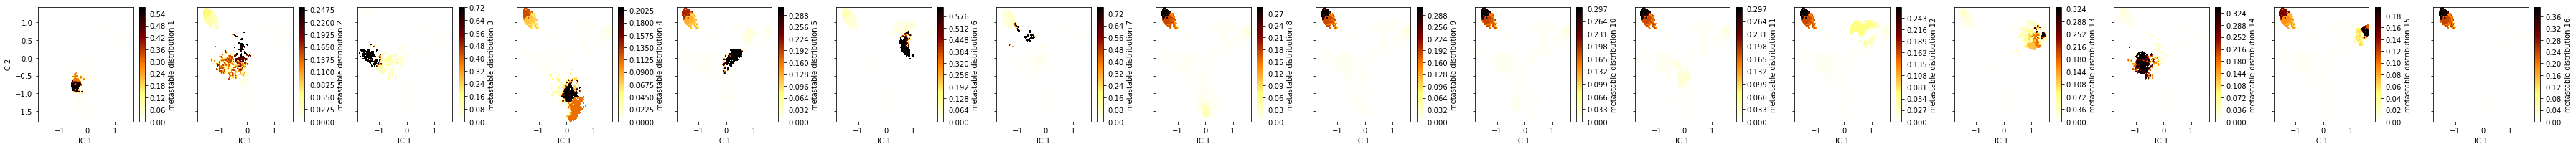

In [44]:
'''
fig=plt.figure()
fig, axes = plt.subplots(1, 16, figsize=(50, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()
fig.savefig(DIR+'/all_metastable states_Ca.pdf')
'''

In [28]:
'''
fig=plt.figure()
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(8, 6))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
fig.savefig(DIR+'/ff__metastable_states_map.pdf')
'''

IndexError: index 68 is out of bounds for axis 0 with size 65

<Figure size 432x288 with 0 Axes>

In [ ]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 3)
positions_source = pyemma.coordinates.source(files, features=positions_feat)
pyemma.coordinates.save_trajs(
    positions_source,
    pcca_samples,
    outfiles=['path to folder/pcca{}_samples.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

In [47]:
'''
def visualize_metastable(samples, cmap, selection='not element H'):
    """ visualize metastable states
    Parameters
    ----------
    samples: list of mdtraj.Trajectory objects
        each element contains all samples for one metastable state.
    cmap: matplotlib.colors.ListedColormap
        color map used to visualize metastable states before.
    selection: str
        which part of the molecule to selection for visualization. For details have a look here:
        http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
    """
    import nglview
    from matplotlib.colors import to_hex

    widget = nglview.NGLWidget()
    widget.clear_representations()
    ref = samples[0]
    for i, s in enumerate(samples):
        s = s.superpose(ref, atom_indices=s.top.select('resid 2 3 and mass > 2'))
        s = s.atom_slice(s.top.select(selection))
        comp = widget.add_trajectory(s)
        comp.add_licorice()

    # this has to be done in a separate loop for whatever reason...
    x = np.linspace(0, 1, num=len(samples))
    for i, x_ in enumerate(x):
        c = to_hex(cmap(x_))
        widget.update_licorice(color=c, component=i, repr_index=i)
        widget.remove_cartoon(component=i)
    return widget
'''

In [48]:
'''
my_samples = [pyemma.coordinates.save_traj(files, idist, outfile=None, top=pdb)
              for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

cmap = mpl.cm.get_cmap('viridis', nstates)
visualize_metastable(my_samples, cmap)
'''

NGLWidget(max_frame=49)

In [16]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.005453	5.211650
2	0.013564	4.300319
3	0.013067	4.337680
4	0.031204	3.467223
5	0.042125	3.167109
6	0.037514	3.283040
7	0.085636	2.457655
8	0.091957	2.386432
9	0.093247	2.372499
10	0.133519	2.013514
11	0.149703	1.899101
12	0.303012	1.193984


In [69]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

ValueError: zero-size array to reduction operation maximum which has no identity

In [70]:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))

ValueError: zero-size array to reduction operation maximum which has no identity

In [71]:
start, final = 1, 3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

IndexError: index 49 is out of bounds for axis 0 with size 49

<Figure size 432x288 with 0 Axes>

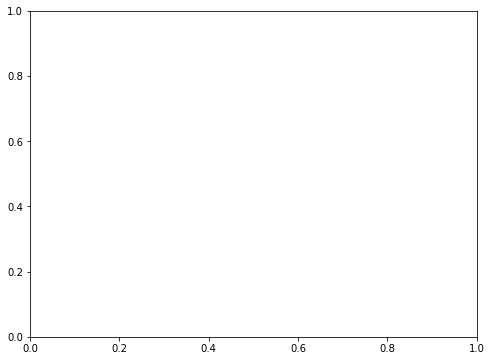

In [42]:
DIR = 'path to folder/bidps'
fig=plt.figure()
fig, ax = plt.subplots(figsize=(8, 6))

pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (
        start + 1, final + 1))
fig.tight_layout()
fig.savefig(DIR+'/bidps_committer.pdf')

In [72]:
print(mfpt)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [73]:
DIR = 'path fo folder/bidps'
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]
fig=plt.figure()
pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray(mfpt),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0, max_width=50,
    state_labels=range(1, nstates + 1),
    size=16);
fig.savefig(DIR+'/bidps_network.pdf')

ValueError: zero-size array to reduction operation maximum which has no identity